## What-if Scenario Generation - TBWISA
---

### 1. Introduction

...

---

### 2. Framework Definition

...

---

### 3. Exploratory Data Analysis

...

#### 3.1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from autots import AutoTS
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
from math import sqrt

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
tf.compat.v1.random.set_random_seed(1234)
tf.compat.v1.disable_eager_execution()

import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))

from source.transformer import TransformerForecasting

Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# Export python packages
# !pip freeze > requirements.txt
# !conda list -e > requirements.txt

#### 3.2. Config parameters

In [ ]:
# Time
time_unit = 'month'

# Scenario generator
item_id = "item_100" # "item_058" used in the report
store_id = "store_001"
price_change_percentages = [-20, -10, 10, 20] # Define price change scenarios in percentage
forecast_length = 12

# Forecasting
forecast_model = "transformer"

# Optimal window
max_window_size = 3  # Restrict the window size to a maximum of 6 time steps

"""
# Tranformer                  # initial              # best results
# ---------------------------------------------------------------------- 
test_size = forecast_length   # forecast_length      # forecast_length
len_display = test_size       # test_size            # test_size
simulation_size = 10          # 10                   # 10
num_layers = 8                # 1                    # 8
size_layer = 128              # 128                  # 128
epoch = 100                   # 300                  # 500
dropout_rate = 0.8            # 0.8                  # 0.7
future_day = test_size        # test_size            # test_size * 2
learning_rate = 0.001         # 0.001                # 0.001
batch_size = 5                # 5                    # 5
"""

# Tranformer                  # initial              # best results
# ---------------------------------------------------------------------- 
simulation_size = 10          # 10                   # 10
num_layers = 8                # 1                    # 8
size_layer = 128              # 128                  # 128
epoch = 100                   # 300                  # 500
dropout_rate = 0.8            # 0.8                  # 0.7
learning_rate = 0.001         # 0.001                # 0.001
batch_size = 5                # 5                    # 5

#### 3.3. Load data

In [4]:
# Load Data
def load_data(file_path):
    """Load historical data from a CSV file."""
    data = pd.read_csv(file_path, parse_dates=True, index_col='timestamp')
    return data

In [5]:
# Load dataset

# Target time series
# https://github.com/aws-samples/amazon-forecast-samples/blob/main/library/content/TargetTimeSeries.md
file_path_tts = '../dataset/consumer_electronics_TTS.csv'
# Related time series
# https://github.com/aws-samples/amazon-forecast-samples/blob/main/library/content/RelatedTimeSeries.md
file_path_rts = '../dataset/consumer_electronics_RTS.csv'

data_tts = load_data(file_path_tts)
data_rts = load_data(file_path_rts)
data_merged = pd.merge(data_rts, data_tts, on=['timestamp','item_id', 'store_id'], how='left')

data_all = data_merged[(data_merged["item_id"] == item_id) & (data_merged["store_id"] == store_id)]
data = data_all[:-3]

filtered_data = data[["price", "demand"]]
#normalized_df=(filtered_data - filtered_data.mean()) / filtered_data.std()
normalized_df=(filtered_data-filtered_data.min())/(filtered_data.max()-filtered_data.min())

In [6]:
data_merged

,item_id,store_id,price,demand
timestamp,,,,
2017-10-01,item_001,store_001,103.000000,305.824943
2017-11-01,item_001,store_001,110.795480,276.942940
2017-12-01,item_001,store_001,110.795480,277.608189
2018-01-01,item_001,store_001,110.795480,275.940622
2018-02-01,item_001,store_001,110.795480,272.387060
...,...,...,...,...
2019-08-01,item_300,store_005,79.321226,362.380115
2019-09-01,item_300,store_005,79.321226,400.226476
2019-10-01,item_300,store_005,79.321226,NaN


#### 3.4. Data Exploration

Correlation between time series ...

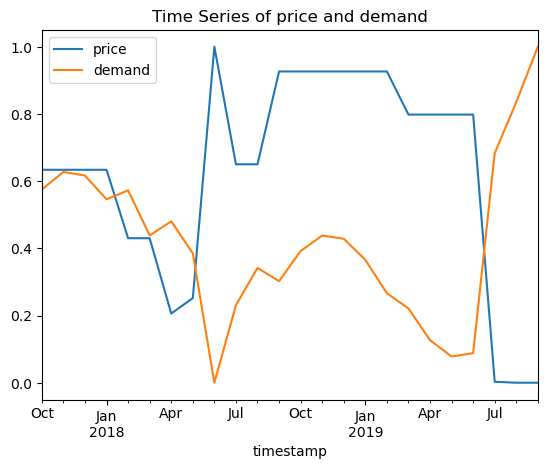

In [7]:
# Plot the time series
normalized_df.plot(title='Time Series of price and demand')
plt.show()

In [8]:
# Calculate the correlation between the two time series
correlation = data['price'].corr(data['demand'])
print(f"Correlation between Price and demand: {correlation:.2f}")

Correlation between Price and demand: -0.72


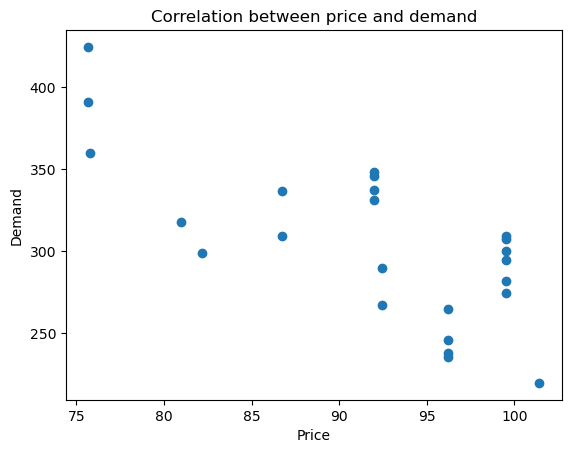

In [9]:
# Plot the scatter plot to visualize correlation
plt.scatter(data['price'], data['demand'])
plt.title(f'Correlation between price and demand')
plt.xlabel('Price')
plt.ylabel('Demand')
plt.show()

---

### 4. Model Construction

...

#### 4.1. Methods

In [ ]:
## Scenario generation

# Calculate price elasticity of demand using a linear regression model
def calculate_elasticity(demand, price):
    regression = LinearRegression()
    log_price = np.log(price).values.reshape(-1, 1)
    log_demand = np.log(demand).values.reshape(-1, 1)
    regression.fit(log_price, log_demand)
    elasticity = regression.coef_[0][0]
    return elasticity

# Non-linear elasticity function
def non_linear_elasticity(price_change, base_elasticity):
    # Quadratic function, with larger price changes having a stronger effect
    return base_elasticity * (1 + 0.5 * price_change**2)

# Apply stochastic adjustment
def apply_randomness(demand, scenario_name, randomness_factor=0.01, cap=0.05):
    # Introduce randomness based on scenario (e.g., larger changes have more variability)
    if 'Price Change' in scenario_name:
        change = int(scenario_name.split()[2].replace('%', ''))
    else:
        change = 0
    randomness = np.random.normal(loc=0, scale=randomness_factor * abs(change), size=len(demand))
    
    # Cap the randomness to prevent extreme deviations
    capped_randomness = np.clip(randomness, -cap, cap)
    
    stochastic_demand = demand * (1 + capped_randomness)
    return stochastic_demand

# Forecasting function using SARIMAX
def forecast_with_sarimax(series, steps=30):
    model = SARIMAX(series, order=(1, 1, 1), seasonal_order=(1, 1, 0, 12))
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=steps)
    return forecast

# Forecasting function using SARIMAX
def forecast_with_transformer(series, steps=30):
    transformer_forecasting = TransformerForecasting()

    series = pd.DataFrame(series)
    minmax = MinMaxScaler().fit(series.astype('float32'))
    df_log = minmax.transform(series.astype('float32'))
    df_train = pd.DataFrame(df_log)

    results = []
    for i in range(simulation_size):
        print('simulation %d'%(i + 1))
        results.append(np.abs(transformer_forecasting.forecast(df_train, minmax, num_layers, size_layer, batch_size, epoch, dropout_rate, forecast_length, learning_rate)))

    results_df = pd.DataFrame(series.iloc[-forecast_length:])
        
    # Adding the number of months to the timestamp index
    results_df.index = results_df.index + pd.DateOffset(months=forecast_length)

    for idx, result in enumerate(results):
        results_df[idx] = result
    results_df['value'] = results_df.mean(axis=1)

    return results_df[["value"]]

# Forecasting function using AutoTS
def forecast_with_autots(series, steps=30):
    #model = AutoTS(forecast_length=steps, frequency='infer', ensemble='simple')
    model = AutoTS(
        forecast_length=steps,
        frequency='infer',
        #prediction_interval=0.95,
        ensemble='simple',
        models_mode='default',              # or 'deep', 'regressor'
        model_list = 'fast_parallel',       #['ARIMA','ETS'],       # or ['ARIMA','ETS'] or "fast", "superfast", "default", "fast_parallel"
        max_generations=4,
        num_validations=2,
        no_negatives=True,
        n_jobs='auto',
        holiday_country='US',
        verbose=0,
    )
    model = model.fit(series)
    prediction = model.predict()
    forecast = prediction.forecast
    return forecast

# Wrapper for selecting the forecasting model
def forecast_data(series, model="autots", steps=30):
    if model == "sarimax":
        return forecast_with_sarimax(series, steps)
    elif model == "transformer":
        return forecast_with_transformer(series, steps)
    elif model == "autots":
        return forecast_with_autots(series, steps)

# Generate scenarios based on price change
def generate_scenarios(data, price_change_percentages):
    base_elasticity = calculate_elasticity(data['demand'], data['price'])
    adjusted_input = {}
    scenarios = {}
    for change in price_change_percentages:
        adjusted_price = data['price'] * (1 + change / 100)
        adjusted_elasticity = non_linear_elasticity(change / 100, base_elasticity)
        adjusted_demand = data['demand'] * (adjusted_price / data['price']) ** adjusted_elasticity
        adjusted_demand = apply_randomness(adjusted_demand, f'Price Change {change}%', randomness_factor=0.005, cap=0.005)
        scenarios[f'Price Change {change}%'] = adjusted_demand
        adjusted_input[f'Price Change {change}%'] = adjusted_price
    return scenarios, adjusted_input

# Apply the what-if scenarios and forecast
def apply_scenarios(data, scenarios, column_name, model="autots", forecast_horizon=30):
    results = {}
    for scenario, value in scenarios.items():
        print("Scenario " + scenario)
        forecasted_data = forecast_data(value, model=model, steps=forecast_horizon)
        forecasted_data.loc[data.index[-1]] = data[column_name][-1]
        forecasted_data.sort_index(inplace=True)
        results[scenario] = forecasted_data
    return results

# Visualize the results
def visualize_results(original_series, forecasted_results, column_name):
    plt.figure(figsize=(14, 7))
    plt.plot(original_series.index, original_series, label='Original ' + str(column_name), color='black')

    for scenario, forecast in forecasted_results.items():
        if scenario == "Baseline":
            plt.plot(forecast.index, forecast, label=scenario, color='black')
        else:
            plt.plot(forecast.index, forecast, label=scenario)
    
    plt.title('What-If Scenario Analysis of ' + str(column_name) + ' with Non-Linear Elasticity')
    plt.xlabel('Date')
    plt.ylabel(column_name)
    plt.legend()
    plt.show()

#### 4.2. Baseline forcast

Forecasting the **price** ...

In [11]:
%%time

baseline_price = forecast_data(data['price'], model=forecast_model, steps=forecast_length)
baseline_price.loc[data.index[-1]] = data["price"][-1]
baseline_price.sort_index(inplace=True)

Init transformer
simulation 1
Instructions for updating:
Use `tf.cast` instead.


/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
Instructions for updating:
Use `tf.cast` instead.
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layers.dense(queries, num_units, name='Q')
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:151: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  K_V = tf.layers.dense(keys, 2*num_units, name='K_V')
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:187: UserWarning: `tf.layers.dense` is deprecated 

simulation 2


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 88.80it/s, acc=89.6, cost=0.0261]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 3


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 85.24it/s, acc=91.2, cost=0.0208]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 4


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 88.11it/s, acc=92.3, cost=0.0174]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 5


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 88.42it/s, acc=90.9, cost=0.0221]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 6


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 87.12it/s, acc=92.9, cost=0.0139]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 7


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 90.07it/s, acc=92.4, cost=0.017]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layers

simulation 8


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 89.88it/s, acc=90.9, cost=0.0199]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 9


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 89.38it/s, acc=93.1, cost=0.0151]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 10


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 87.01it/s, acc=92.6, cost=0.0159]


CPU times: user 19.3 s, sys: 5 s, total: 24.3 s
Wall time: 15.7 s


Forecasting the **demand** ...

In [12]:
%%time

baseline_demand = forecast_data(data['demand'], model=forecast_model, steps=forecast_length)

baseline_demand.loc[data.index[-1]] = data["demand"][-1]
baseline_demand.sort_index(inplace=True)

/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layers.dense(queries, num_units, name='Q')
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:151: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  K_V = tf.layers.dense(keys, 2*num_units, name='K_V')
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:187: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please us

Init transformer
simulation 1


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 88.63it/s, acc=92, cost=0.0142]  
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 2


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 88.45it/s, acc=94.6, cost=0.00592]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.laye

simulation 3


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 89.01it/s, acc=94.3, cost=0.00665]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.laye

simulation 4


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 88.21it/s, acc=94.4, cost=0.00668]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.laye

simulation 5


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 87.72it/s, acc=93.1, cost=0.00928]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.laye

simulation 6


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 86.76it/s, acc=94.6, cost=0.00605]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.laye

simulation 7


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 83.13it/s, acc=92.6, cost=0.0101]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 8


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 86.82it/s, acc=94, cost=0.00683] 
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 9


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 89.44it/s, acc=93.8, cost=0.009] 
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 10


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 89.15it/s, acc=94.5, cost=0.00683]


CPU times: user 19 s, sys: 4.97 s, total: 24 s
Wall time: 15.6 s


#### 4.3. Scenario generation

**Create** the scenarios ...

In [13]:
# Generate scenarios
scenarios, adjusted_input = generate_scenarios(data, price_change_percentages)

**Forecasting** values of *price* for each scenario ...

In [14]:
%%time

# Apply scenarios and forecast
forecasted_price = apply_scenarios(data, adjusted_input, "price", model=forecast_model, forecast_horizon=forecast_length)
forecasted_price["Baseline"] = baseline_price

/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layers.dense(queries, num_units, name='Q')
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:151: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  K_V = tf.layers.dense(keys, 2*num_units, name='K_V')
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:187: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please us

Scenario Price Change -20%
Init transformer
simulation 1


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 91.14it/s, acc=92.3, cost=0.0175]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 2


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 87.84it/s, acc=89.2, cost=0.0255]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 3


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 88.90it/s, acc=92.9, cost=0.0153]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 4


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 88.68it/s, acc=92.6, cost=0.018]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layers

simulation 5


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 88.22it/s, acc=84.7, cost=0.0567]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 6


/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:132: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.layers.dense(encoder_embedded[-1], output_size)
/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 92.06it/s, acc=91.8, cost=0.0185]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encod

simulation 7


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 91.24it/s, acc=92.9, cost=0.0167]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 8


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 91.08it/s, acc=92.6, cost=0.02] 
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layers

simulation 9


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 86.99it/s, acc=89.6, cost=0.0299]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 10


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 91.85it/s, acc=90.2, cost=0.0237]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

Scenario Price Change -10%
Init transformer
simulation 1


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 90.57it/s, acc=92.5, cost=0.0164]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 2


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 91.62it/s, acc=92.1, cost=0.0185]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 3


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 91.61it/s, acc=91.1, cost=0.0199]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 4


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 89.13it/s, acc=90.7, cost=0.0223]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 5


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 90.88it/s, acc=90.4, cost=0.0266]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 6


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 91.42it/s, acc=91, cost=0.0251] 
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layers

simulation 7


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 91.47it/s, acc=91.7, cost=0.0195]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 8


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 89.79it/s, acc=93.7, cost=0.0157]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 9


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 87.91it/s, acc=87.3, cost=0.0382]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 10


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 91.55it/s, acc=90.5, cost=0.0227]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

Scenario Price Change 10%
Init transformer
simulation 1


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 90.50it/s, acc=92.3, cost=0.0199]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 2


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 91.07it/s, acc=90.5, cost=0.0218]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 3


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 90.78it/s, acc=92.6, cost=0.0179]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 4


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 90.88it/s, acc=92, cost=0.0186] 
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layers

simulation 5


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 90.79it/s, acc=92.9, cost=0.0177]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 6


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 92.09it/s, acc=92.3, cost=0.018]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layers

simulation 7


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 88.40it/s, acc=88.6, cost=0.0271]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 8


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 90.94it/s, acc=91.4, cost=0.0206]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 9


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 92.08it/s, acc=90.1, cost=0.0236]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 10


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 91.30it/s, acc=91.3, cost=0.0191]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

Scenario Price Change 20%
Init transformer
simulation 1


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 91.02it/s, acc=91.3, cost=0.0205]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 2


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 91.39it/s, acc=89, cost=0.0315] 
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layers

simulation 3


/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:151: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  K_V = tf.layers.dense(keys, 2*num_units, name='K_V')
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:187: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  outputs = tf.layers.dense(inputs, 4*hidden_units, activation=activation)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:188: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  outputs = tf.layers.dense(outputs, hidden_units, activation=None)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:132: UserWarning: `tf.layers.dense` is deprecated and will be removed

simulation 4


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 91.92it/s, acc=87.5, cost=0.0354]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 5


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 90.59it/s, acc=91.3, cost=0.0215]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 6


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 90.23it/s, acc=92.8, cost=0.0181]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 7


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 91.56it/s, acc=88.9, cost=0.028]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layers

simulation 8


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 91.28it/s, acc=92.6, cost=0.0154]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 9


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 91.07it/s, acc=91.6, cost=0.0191]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 10


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 91.36it/s, acc=90.9, cost=0.022]


CPU times: user 1min 15s, sys: 18.4 s, total: 1min 33s
Wall time: 1min 1s


**Forecasting** values of *demand* for each scenario ...

In [15]:
%%time

# Apply scenarios and forecast
forecasted_demand = apply_scenarios(data, scenarios, "demand", model=forecast_model, forecast_horizon=forecast_length)
forecasted_demand["Baseline"] = baseline_demand

/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layers.dense(queries, num_units, name='Q')
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:151: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  K_V = tf.layers.dense(keys, 2*num_units, name='K_V')
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:187: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please us

Scenario Price Change -20%
Init transformer
simulation 1


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 91.93it/s, acc=94.5, cost=0.00619]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.laye

simulation 2


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 90.36it/s, acc=93.7, cost=0.00933]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.laye

simulation 3


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 90.79it/s, acc=92.7, cost=0.0119]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 4


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 89.21it/s, acc=93, cost=0.0108]  
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 5


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 91.72it/s, acc=92.5, cost=0.0124]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 6


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 90.90it/s, acc=93.4, cost=0.00905]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.laye

simulation 7


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 90.42it/s, acc=94.4, cost=0.00751]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.laye

simulation 8


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 91.66it/s, acc=94, cost=0.00965] 
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 9


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 88.60it/s, acc=94.1, cost=0.00755]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.laye

simulation 10


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 91.32it/s, acc=92.9, cost=0.0129]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

Scenario Price Change -10%
Init transformer
simulation 1


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 91.25it/s, acc=94.3, cost=0.00716]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.laye

simulation 2


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 92.55it/s, acc=92.4, cost=0.0129]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 3


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 92.17it/s, acc=92.6, cost=0.0137]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 4


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 91.07it/s, acc=94.6, cost=0.00645]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.laye

simulation 5


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 88.50it/s, acc=93.7, cost=0.008] 
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 6


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 91.59it/s, acc=92.6, cost=0.0112]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 7


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 92.18it/s, acc=92.8, cost=0.00964]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.laye

simulation 8


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 91.42it/s, acc=94.3, cost=0.00631]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.laye

simulation 9


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 91.24it/s, acc=93.4, cost=0.0092]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 10


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 89.92it/s, acc=94.7, cost=0.00575]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.laye

Scenario Price Change 10%
Init transformer
simulation 1


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 92.08it/s, acc=93.8, cost=0.00766]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.laye

simulation 2


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 91.27it/s, acc=93.2, cost=0.00897]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.laye

simulation 3


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 91.86it/s, acc=93.7, cost=0.0091]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 4


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 92.13it/s, acc=94.2, cost=0.00947]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.laye

simulation 5


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 91.48it/s, acc=93.9, cost=0.00833]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.laye

simulation 6


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 91.86it/s, acc=95, cost=0.00612] 
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 7


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 92.68it/s, acc=92.7, cost=0.0135]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 8


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 92.13it/s, acc=94.6, cost=0.00641]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.laye

simulation 9


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 91.14it/s, acc=94.8, cost=0.00625]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.laye

simulation 10


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 90.61it/s, acc=93.6, cost=0.00818]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.laye

Scenario Price Change 20%
Init transformer
simulation 1


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 92.02it/s, acc=93.3, cost=0.0111]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 2


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 92.53it/s, acc=93.4, cost=0.00846]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.laye

simulation 3


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 88.70it/s, acc=93.4, cost=0.0104]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 4


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 91.82it/s, acc=93.6, cost=0.00954]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.laye

simulation 5


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 92.24it/s, acc=94.9, cost=0.00651]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.laye

simulation 6


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 92.70it/s, acc=94, cost=0.00783] 
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layer

simulation 7


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 92.31it/s, acc=94.8, cost=0.00563]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.laye

simulation 8


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 90.94it/s, acc=95.1, cost=0.00543]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.laye

simulation 9


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 92.62it/s, acc=93.7, cost=0.00872]
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:111: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
/Users/alexgrigoras/Github/scenario-generation/notebooks/../source/transformer.py:150: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.laye

simulation 10


/Users/alexgrigoras/miniforge3/envs/synthetic-data-env/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 100/100 [00:01<00:00, 92.64it/s, acc=91.7, cost=0.0135]


CPU times: user 1min 15s, sys: 18.2 s, total: 1min 33s
Wall time: 1min


---

### 5. Model Evaluation

...

In [16]:
# ...

---

### 6. Model Results

...

#### 6.1. Methods

In [17]:
# Function to prepare the dataset for training the model with a quadratic penalty for large windows
def prepare_training_data_with_quadratic_penalty(forecasted_revenue, max_window_size, penalty_factor=0.1):
    X = []
    y = []
    for scenario, revenue_series in forecasted_revenue.items():
        revenue_values = revenue_series.values
        
        for window_size in range(1, max_window_size + 1):
            for start in range(len(revenue_values) - window_size + 1):
                window_revenue = revenue_values[start:start + window_size]
                total_profit = np.sum(window_revenue)
                rolling_mean = np.mean(window_revenue)
                rolling_std = np.std(window_revenue)

                # Apply quadratic penalty based on window size
                window_size_penalty = penalty_factor * (window_size ** 2)

                X.append([
                    start,  # Start index
                    window_size,  # Window size
                    rolling_mean,  # Mean revenue
                    rolling_std,  # Std deviation in window
                    window_size_penalty  # Quadratic penalty term for large windows
                ])
                y.append(total_profit)

    return np.array(X), np.array(y)

# Function to determine the optimal profit window using the model with a quadratic penalty for large windows
def find_optimal_window_with_quadratic_penalty(forecasted_revenue, model, max_window_size, penalty_factor=0.1):
    optimal_result = {
        "scenario": None,
        "start_index": None,
        "end_index": None,
        "profit": float('-inf')
    }

    for scenario, revenue_series in forecasted_revenue.items():
        revenue_values = revenue_series.values
        scenario_X = []
        scenario_indices = []

        for window_size in range(1, max_window_size + 1):
            for start in range(len(revenue_values) - window_size + 1):
                window_revenue = revenue_values[start:start + window_size]
                rolling_mean = np.mean(window_revenue)
                rolling_std = np.std(window_revenue)

                # Apply quadratic penalty based on window size
                window_size_penalty = penalty_factor * (window_size ** 2)

                scenario_X.append([
                    start,
                    window_size,
                    rolling_mean,
                    rolling_std,
                    window_size_penalty  # Quadratic penalty term
                ])
                scenario_indices.append((start, start + window_size - 1))
        
        scenario_X = np.array(scenario_X)
        predicted_profits = model.predict(scenario_X)
        best_window_idx = np.argmax(predicted_profits)

        if predicted_profits[best_window_idx] > optimal_result["profit"]:
            optimal_result.update({
                "scenario": scenario,
                "start_index": scenario_indices[best_window_idx][0],
                "end_index": scenario_indices[best_window_idx][1],
                "profit": predicted_profits[best_window_idx]
            })

    return optimal_result

# Visualization of the results with quadratic penalty
def visualize_optimal_window_with_history(original_series, forecasted_revenue, optimal_window_ml):
    """
    Visualizes the forecasted results with the optimal profit window highlighted, along with the historical series.

    Args:
    - original_series: The original time series data (historical values).
    - forecasted_revenue: Dictionary of forecasted revenue scenarios.
    - optimal_window_ml: Dictionary containing details about the optimal profit window.
    """
    plt.figure(figsize=(14, 7))
    
    # Plot the original (historical) revenue series in black
    plt.plot(original_series.index, original_series.values, label='Original Series', color='black', linewidth=2)
    
    # Initialize variable to track the global minimum y-value for all plots
    global_min_value = original_series.min()  # Start with the min value from historical data
    
    # Plot the forecasted revenue for each scenario and update the global minimum
    for scenario, forecast in forecasted_revenue.items():
        # Ensure forecast is a Series and use the first column if it's a DataFrame
        if isinstance(forecast, pd.DataFrame):
            forecast = forecast.iloc[:, 0]
        
        plt.plot(forecast.index, forecast.values, label=f'Forecasted: {scenario}')
        global_min_value = min(global_min_value, forecast.min())  # Safely update the global minimum
    
    # Extract optimal scenario, start index, and end index
    optimal_scenario = optimal_window_ml['scenario']
    start_idx = optimal_window_ml['start_index']
    end_idx = optimal_window_ml['end_index']
    
    # Extract the specific scenario's forecasted revenue series
    optimal_forecast = forecasted_revenue[optimal_scenario]
    if isinstance(optimal_forecast, pd.DataFrame):
        optimal_forecast = optimal_forecast.iloc[:, 0]  # Take the first column if it's a DataFrame
    
    # Get the optimal window based on start and end indices
    optimal_window = optimal_forecast.iloc[start_idx:end_idx + 1]
    
    # Highlight the optimal window on the plot
    plt.fill_between(
        optimal_window.index,  # Use the index for x-axis (time)
        global_min_value,  # Lower bound (global minimum of all scenarios)
        optimal_window.values,  # Upper bound (actual values for the window)
        color='yellow',  # Color for the optimal window
        alpha=0.3,  # Transparency
        label=f'Optimal Window: {optimal_scenario} ({start_idx}-{end_idx})'
    )

    # Add plot labels, title, and legend
    plt.title('Forecasted Revenue with Optimal Profit Window Highlighted')
    plt.xlabel('Time')
    plt.ylabel('Revenue')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

#### 6.2. Forecasting

...

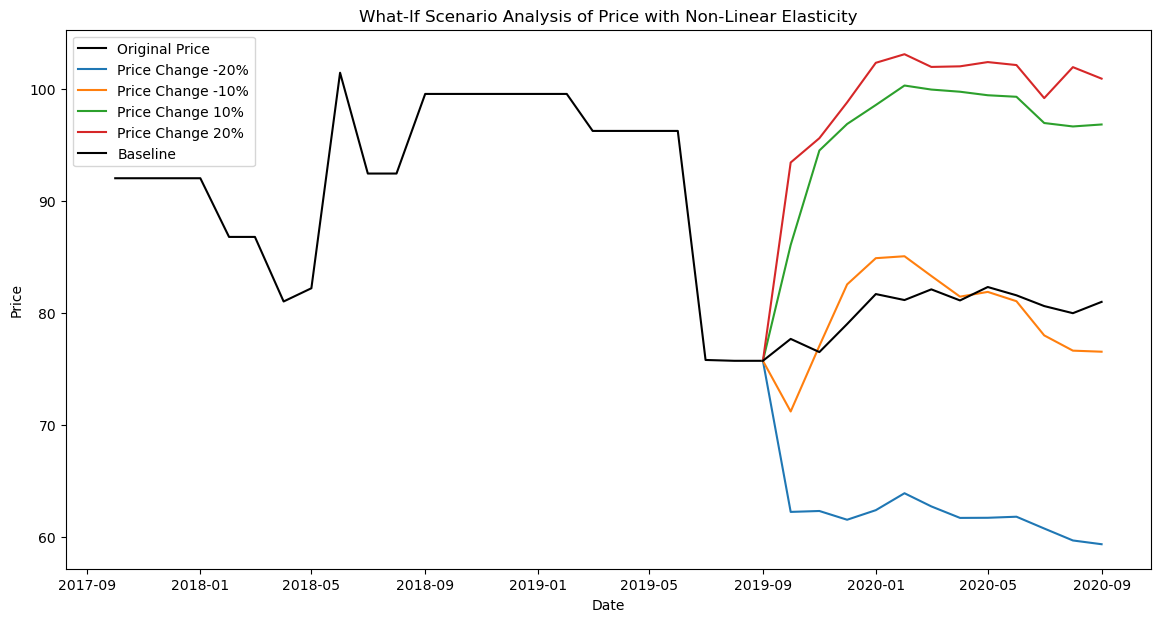

In [18]:
# Visualize the results
visualize_results(data['price'], forecasted_price, "Price")

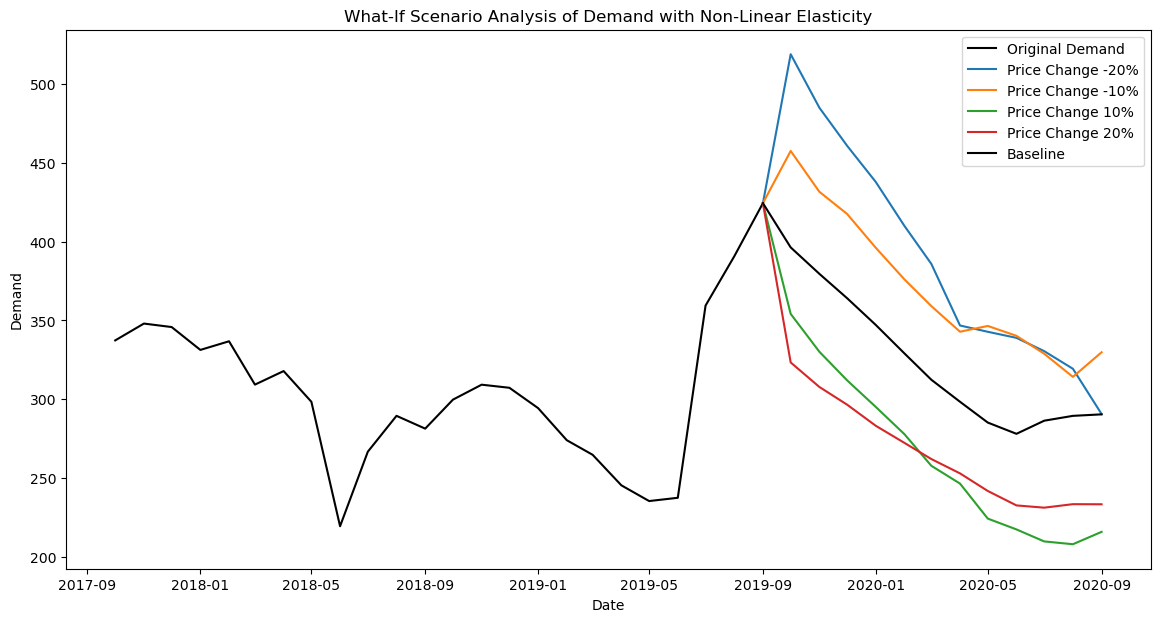

In [19]:
# Visualize the results
visualize_results(data['demand'], forecasted_demand, "Demand")

#### 6.3. Results

Total **revenue** ...

In [20]:
# Calculate revenue

data['revenue'] = data['price'] * data['demand']

forecasted_revenue = {}
total_revenue = {}
for price_scenario, demand_df in forecasted_demand.items():
    price_df = forecasted_price.get(price_scenario)
    if price_df is not None:
        revenue_df = demand_df * price_df
        forecasted_revenue[price_scenario] = revenue_df
        total_revenue[price_scenario] = revenue_df.sum().values[0]

for scenario, total_rev in total_revenue.items():
    print(f"{scenario} - Total Revenue: {total_rev:.2f}")

Price Change -20% - Total Revenue: 320416.45
Price Change -10% - Total Revenue: 386664.98
Price Change 10% - Total Revenue: 336610.24
Price Change 20% - Total Revenue: 349486.35
Baseline - Total Revenue: 341477.93


/var/folders/lj/dwbsfn1d6k592c_f3y7j6xmm0000gn/T/ipykernel_42940/654697751.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['revenue'] = data['price'] * data['demand']


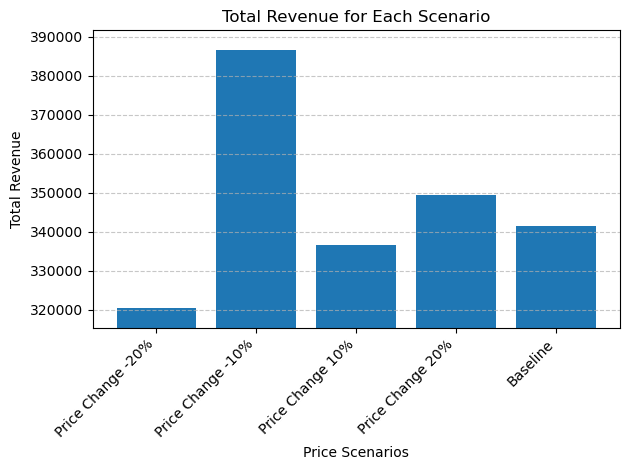

In [21]:
# Plot the total revenue for each scenario
plt.figure()
plt.bar(total_revenue.keys(), total_revenue.values())
plt.ylim([min(total_revenue.values()) - 5000, max(total_revenue.values()) + 5000])
plt.title('Total Revenue for Each Scenario')
plt.xlabel('Price Scenarios')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

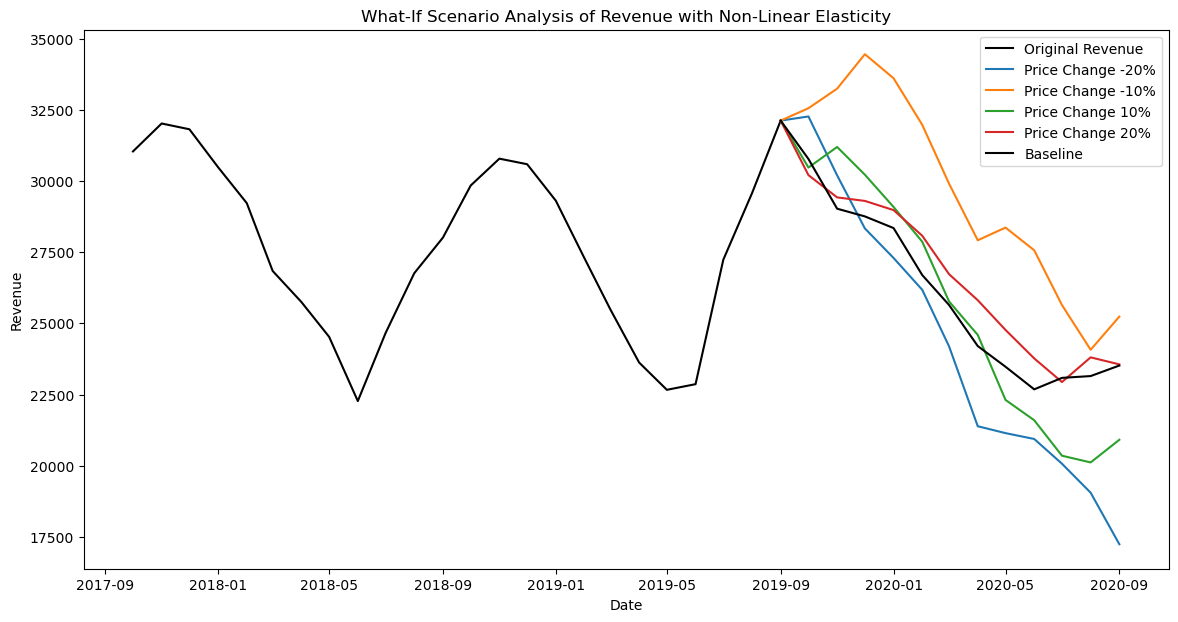

In [22]:
# Visualize the results
visualize_results(data['revenue'], forecasted_revenue, "Revenue")

#### 6.4. Optimal window

The optimal profit window generation process involves finding a specific time segment within the forecast period that maximizes profit. Instead of assuming that the entire forecast length is optimal, the algorithm identifies the most profitable subset of the forecast, which could vary in size (from as small as one time step to the full forecast length) ...

Mean Absolute Error: 479.75950535430627
R^2 Score: 0.9986053182902994
Optimal Scenario: Price Change -10%
Window: 2 to 4
Profit: 100796.39


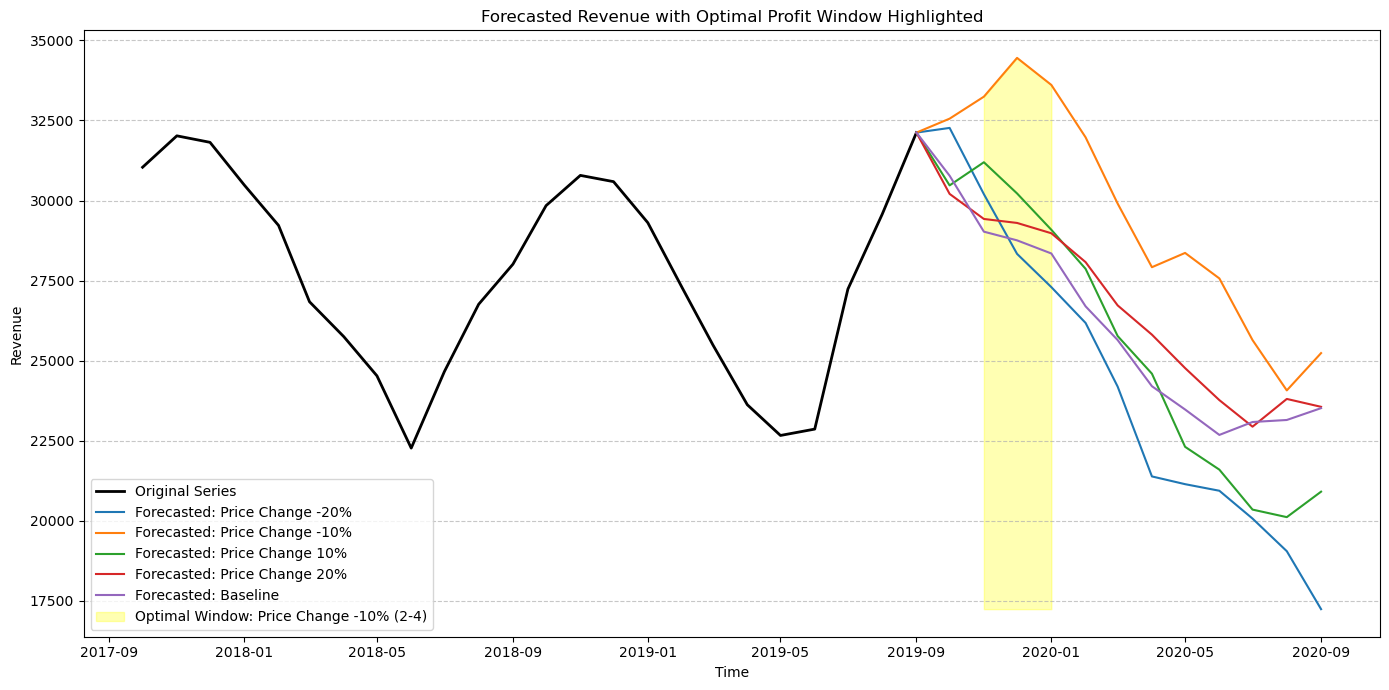

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# Training data preparation with quadratic penalty
max_window_size = 3  # Limit the window size
penalty_factor = 0.05  # Reduced penalty factor for larger windows
X, y = prepare_training_data_with_quadratic_penalty(forecasted_revenue, max_window_size, penalty_factor)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("R^2 Score:", r2_score(y_test, y_pred))

# Determine the optimal window with quadratic penalty
optimal_window_ml = find_optimal_window_with_quadratic_penalty(forecasted_revenue, model, max_window_size, penalty_factor)
print(f"Optimal Scenario: {optimal_window_ml['scenario']}")
print(f"Window: {optimal_window_ml['start_index']} to {optimal_window_ml['end_index']}")
print(f"Profit: {optimal_window_ml['profit']:.2f}")

# Assuming you have a DataFrame `original_series` and a dictionary `forecasted_revenue` with the optimal result
visualize_optimal_window_with_history(data['revenue'], forecasted_revenue, optimal_window_ml)